In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi 

Fri Apr 29 11:13:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
x_train_dir = '/content/drive/My Drive/MedicalImage_Project02_Segmentation/data/FA/train/imgs/'
y_train_dir = '/content/drive/My Drive/MedicalImage_Project02_Segmentation/data/FA/train/masks/'
x_valid_dir = '/content/drive/My Drive/MedicalImage_Project02_Segmentation/data/FA/test/imgs/'
y_valid_dir = '/content/drive/My Drive/MedicalImage_Project02_Segmentation/data/FA/test/masks/'
x_test_dir = '/content/drive/My Drive/MedicalImage_Project02_Segmentation/data/FA/test/imgs/'
y_test_dir = '/content/drive/My Drive/MedicalImage_Project02_Segmentation/data/FA/test/masks/'
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [4]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import numpy as np
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """

    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            # classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id[-13:]) for image_id in self.images_fps]

        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        # print(mask)
        mask = cv2.resize(mask, (512, 512))
        image = cv2.resize(image, (512, 512))
        # tem=image.shape[0]
        # print(tem)
        mask=mask.astype('float32')/255.0
        image=image.astype('float32')/255.0
        # tem2=int((512-tem)/2)
        # if(int((512-tem)%2)==1):
        #   mask=np.pad(np.array(mask),((tem2,tem2+1),(tem2,tem2+1)),'constant',constant_values = ((0,0)))
        #   mask=mask.astype('float32')/255.0
        #   image1=np.pad(np.array(image[:,:,0]),((tem2,tem2+1),(tem2,tem2+1)),'constant',constant_values = ((0,0)))
        #   image1=image1.astype('float32')/255.0
        #   image2=np.pad(np.array(image[:,:,1]),((tem2,tem2+1),(tem2,tem2+1)),'constant',constant_values = ((0,0)))
        #   image2=image2.astype('float32')/255.0
        #   image3=np.pad(np.array(image[:,:,2]),((tem2,tem2+1),(tem2,tem2+1)),'constant',constant_values = ((0,0)))
        #   image3=image3.astype('float32')/255.0
        # else:
        #   mask=np.pad(np.array(mask),((tem2,tem2),(tem2,tem2)),'constant',constant_values = ((0,0)))
        #   mask=mask.astype('float32')/255.0
        #   image1=np.pad(np.array(image[:,:,0]),((tem2,tem2),(tem2,tem2)),'constant',constant_values = ((0,0)))
        #   image1=image1.astype('float32')/255.0
        #   image2=np.pad(np.array(image[:,:,1]),((tem2,tem2),(tem2,tem2)),'constant',constant_values = ((0,0)))
        #   image2=image2.astype('float32')/255.0
        #   image3=np.pad(np.array(image[:,:,2]),((tem2,tem2),(tem2,tem2)),'constant',constant_values = ((0,0)))
        #   image3=image3.astype('float32')/255.0
        # image=np.dstack((image1,image2,image3))
        mask=np.expand_dims(np.array(mask),axis=2)
        mask=mask.transpose(2, 0, 1).astype('float32')
        image=image.transpose(2, 0, 1).astype('float32')
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

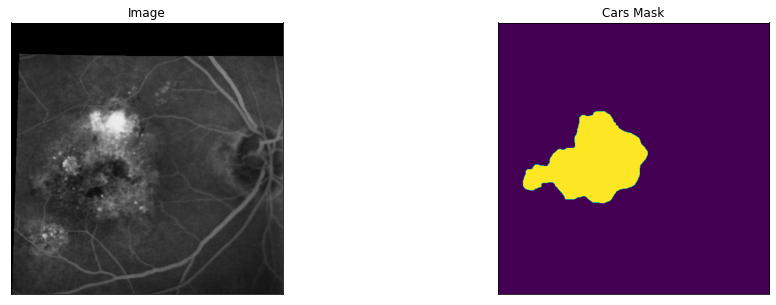

In [ ]:
# Lets look at data we have

dataset = Dataset(x_train_dir, y_train_dir)

image, mask = dataset[15] # get some sample
visualize(
    image=image.transpose(1,2,0).astype('float32'), 
    cars_mask=mask.transpose(1,2,0).astype('int64')[:,:,0],
)

#train

In [5]:
pip install segmentation_models_pytorch

     |████████████████████████████████| 88 kB 3.2 MB/s 
     |████████████████████████████████| 58 kB 5.4 MB/s 
     |████████████████████████████████| 376 kB 32.5 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=a1067752b7c2bde660d2cd1e93b7a682e5c6bdf818b1a9a0ab520e2c7721c7b5
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=09d9ed4e00b3d44af924a6af0743b1febd11547b0bc2fe85834f8967d6fa59a2
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [6]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [7]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
)
total = sum([param.nelement() for param in model.parameters()])
print("Number of parameter: %.2fM" % (total/1e6))

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Number of parameter: 32.52M


In [ ]:
torch.cuda.empty_cache()

In [ ]:
print(torch.cuda.memory_summary())

In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

In [8]:
from torchvision import transforms
data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir,
    data_transform, 
    # augmentation=get_training_augmentation(), 
    # preprocessing=get_preprocessing(preprocessing_fn),
    # classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    data_transform, 
    # augmentation=get_validation_augmentation(), 
    # preprocessing=get_preprocessing(preprocessing_fn),
    # classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False)#, num_workers=1
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

#optimizer = torch.optim.Adam([ 
#    dict(params=model.parameters(), lr=0.0001),
#])
optimizer = torch.optim.SGD([ 
    dict(params=model.parameters(), lr=0.01,momentum=0.9),
])
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)
max_score = 0

for i in range(1, 21):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    #with open('TrainingAccuracy.txt','a') as fAcc:
    #        print('{:.4f} '.format(train_logs['iou_score']), file = fAcc)
    #with open('TrainingLoss.txt','a') as fLoss:
    #        print('{:.4f} '.format(training_loss), file = fLoss)

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        torch.save(model, '/content/drive/My Drive/MedicalImage_Project02_Segmentation/best_model.pth')
        print('Model saved!')
        
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 1
valid: 100%|██████████| 14/14 [00:31<00:00,  2.28s/it, dice_loss - 0.8884, iou_score - 0.05614]
Model saved!

Epoch: 2
valid: 100%|██████████| 14/14 [00:06<00:00,  2.28it/s, dice_loss - 0.7164, iou_score - 0.2157]
Model saved!

Epoch: 3
valid: 100%|██████████| 14/14 [00:05<00:00,  2.38it/s, dice_loss - 0.6623, iou_score - 0.217]
Model saved!

Epoch: 4
valid: 100%|██████████| 14/14 [00:06<00:00,  2.32it/s, dice_loss - 0.5739, iou_score - 0.3017]
Model saved!

Epoch: 5
valid: 100%|██████████| 14/14 [00:05<00:00,  2.39it/s, dice_loss - 0.5516, iou_score - 0.3155]
Model saved!

Epoch: 6
valid: 100%|██████████| 14/14 [00:05<00:00,  2.34it/s, dice_loss - 0.7649, iou_score - 0.1458]

Epoch: 7
valid: 100%|██████████| 14/14 [00:05<00:00,  2.34it/s, dice_loss - 0.6028, iou_score - 0.2746]

Epoch: 8
valid: 100%|██████████| 14/14 [00:06<00:00,  2.30it/s, dice_loss - 0.444, iou_score - 0.4204]
Model saved!

Epoch: 9
valid: 100%|██████████| 14/14 [00:05<00:00,  2.37it/s, dice_loss - 0.5532

#test

In [9]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')
#best_model = torch.load('/content/drive/My Drive/MedicalImage_Project02_Segmentation/resnet50-unetplus-.pth')

In [10]:
from torchvision import transforms
data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    data_transform, 
    # augmentation=get_validation_augmentation(), 
    # preprocessing=get_preprocessing(preprocessing_fn),
    # classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 55/55 [00:07<00:00,  7.35it/s, dice_loss - 0.472, iou_score - 0.4071]


#可視化

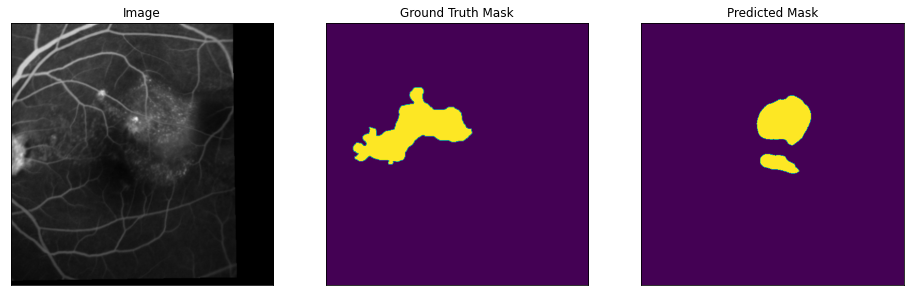

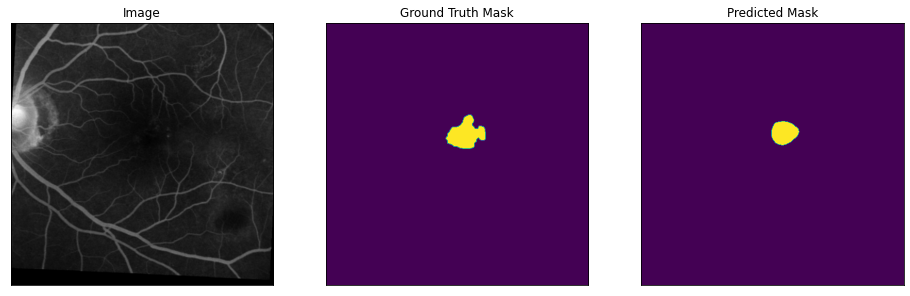

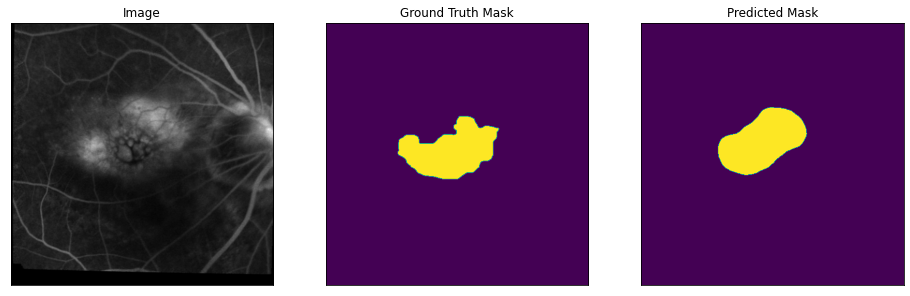

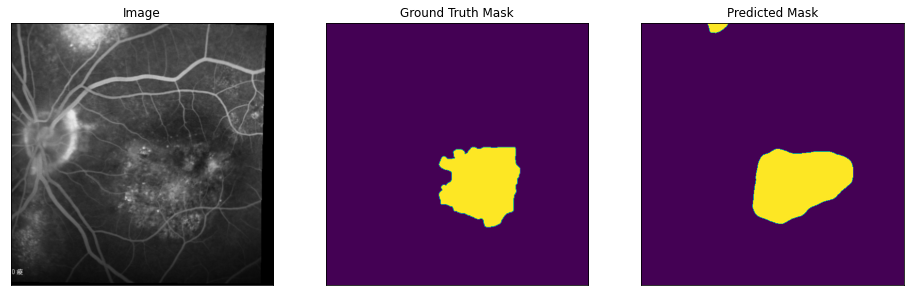

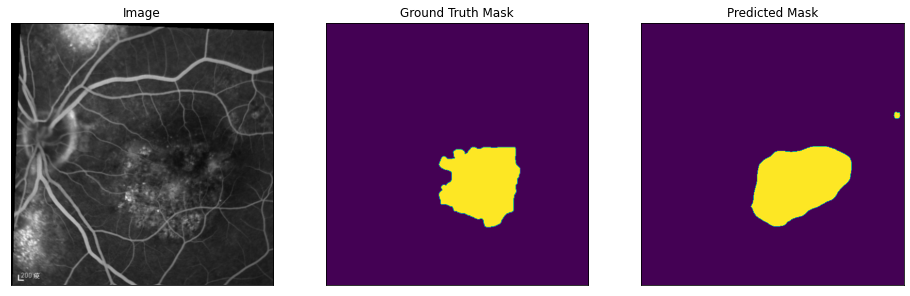

In [ ]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    # classes=CLASSES,
)
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('float32')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis.transpose(1,2,0), 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

    # image=image.transpose(1,2,0), 
    # cars_mask=mask.transpose(1,2,0).astype('int64')[:,:,0],

#抽取樣本

In [ ]:
import os, random, shutil
def moveFile(fileDir,fileDir2):
  pathDir = os.listdir(fileDir)    #取圖片的原始路徑
  filenumber=len(pathDir)
  rate=0.2    #自定義抽取圖片的比例，比方說100張抽10張，那就是0.1
  picknumber=int(filenumber*rate) #按照rate比例從資料夾中取一定數量圖片
  sample = random.sample(pathDir, picknumber)  #隨機選取picknumber數量的樣本圖片
  print (sample)
  for name in sample:
          shutil.move(fileDir+name, tarDir+name)
          shutil.move(fileDir2+name, tarDir2+name)
  return
 
if __name__ == '__main__':
    fileDir = "/content/drive/My Drive/Colab Notebooks/medical image2/data/FA/train/imgs/"    #源圖片資料夾路徑
    tarDir = '/content/drive/My Drive/Colab Notebooks/medical image2/data/FA/val/imgs/'    #移動到新的資料夾路徑
    
    fileDir2 = "/content/drive/My Drive/Colab Notebooks/medical image2/data/FA/train/masks/"    #源圖片資料夾路徑
    tarDir2 = '/content/drive/My Drive/Colab Notebooks/medical image2/data/FA/val/masks/'    #移動到新的資料夾路徑
    moveFile(fileDir,fileDir2)  

['0141_03_2.png', '0142_04_1.png', '0121_03_2.png', '0132_07_1.png', '0121_13_3.png', '0101_12_5.png', '0101_03_1.png', '0132_07_4.png', '0142_05_4.png', '0141_08_5.png', '0131_11_4.png', '0101_20_1.png', '0121_13_1.png', '0121_12_3.png', '0101_11_5.png', '0131_08_1.png', '0111_11_5.png', '0121_10_5.png', '0132_04_5.png', '0101_11_1.png', '0132_04_3.png', '0132_07_5.png', '0111_02_3.png', '0111_14_2.png', '0121_04_1.png', '0121_05_2.png', '0131_04_4.png', '0131_02_3.png', '0121_15_2.png', '0131_03_2.png', '0111_08_1.png', '0121_05_1.png', '0111_14_1.png', '0111_09_4.png', '0101_14_4.png', '0101_20_4.png', '0101_02_1.png', '0121_04_4.png', '0132_07_3.png', '0121_05_5.png', '0142_05_3.png', '0131_05_2.png', '0111_09_5.png', '0121_07_3.png', '0111_07_3.png']
